<a href="https://colab.research.google.com/github/rtphokie/current_nws_warnings/blob/dev/current_nws_warnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title imports and constants

try:
  from mpl_toolkits.basemap import Basemap
except:
  !apt-get install libgeos-dev
  !pip install https://github.com/matplotlib/basemap/archive/master.zip
  %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import requests
import os
import logging
from pprint import pprint
FORMAT = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(format=FORMAT, filename='mapping.log',level=logging.DEBUG)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

# Constants
earth_radius_major = 6378137.000 # useful for more accurate rendering of Mercator and Lambert projections
earth_radius_minor = 6356752.3142

In [0]:
#@title shapefile functions
def load_shapefile_from_git(m, dir, filename, drawbounds=False, 
                            urlbase='https://raw.githubusercontent.com/rtphokie/RAHFeb2020SnowEvent/master'):
  for ext in ['dbf', 'shp', 'shx']:
    if not os.path.exists(f"{dir}/{filename}.{ext}"):
      if not os.path.exists(dir):
        logging.info(f"directory {dir} created")
        os.makedirs(dir)
      url = f'{urlbase}/{dir}/{filename}.{ext}'
      r = requests.get(url)
      logging.info(f'shapefile fetched from GIT {url}')
      with open(f"{dir}/{filename}.{ext}", 'wb') as f:
        f.write(r.content)
    # else:
      logging.debug(f'using existing {ext} shapefile {filename}')
  m.readshapefile(f'{dir}/{filename}', filename, ax=ax, drawbounds=drawbounds)
  logging.info(f"{dir}/{filename} shapefile loaded")



In [0]:
#@title mapping functions

def draw_map_background(m, ax):
    ax.set_facecolor('#729FCF')
    m.fillcontinents(color='#FAFAFA', ax=ax, zorder=0)
    m.drawcounties(ax=ax, color="darkgrey")
    m.drawstates(ax=ax, color='darkgrey')
    m.drawcountries(ax=ax)
    m.drawcoastlines(ax=ax)
  
def draw_shapes(m, ax, dmas=['RALEIGH-DURHAM'], wfos=['RAH']):
    # m.readshapefile('https://github.com/rtphokie/RAHFeb2020SnowEvent/tree/master/dma_2008/DMAs', 'DMAs', ax=ax, drawbounds=False)
    load_shapefile_from_git(m, 'dma_2008', 'DMAs')
    load_shapefile_from_git(m, 'w_03mr20', 'w_03mr20')
    load_shapefile_from_git(m, 'NWS_actual', 'NWS_Actual_polygon', drawbounds=False)

    # m.readshapefile('mygeodata/NWS_Actual-polygon', 'NWS_Actual_polygon', ax=ax, drawbounds=True)
    #https://twitter.com/NWSRaleigh/status/1232344049568354307

    patches= {'0-0.5': [],
              '2-3': [],
              '3-4': [],
              '4-5': [],
              }  

    for info, shape in zip(m.NWS_Actual_polygon_info, m.NWS_Actual_polygon):
        if info['Name'] in patches.keys():
          patches[info['Name']].append( Polygon(np.array(shape), True) )
    pprint(patches)
    ax.add_collection(PatchCollection(patches['2-3'], edgecolor='k', linewidths=1., zorder=2))
    ax.add_collection(PatchCollection(patches['4-5'], edgecolor='k', alpha=0.5, linewidths=1., zorder=2))
    return
    wfos=[]
    for info, shape in zip(m.w_03mr20_info, m.w_03mr20):
      # print(info)
      if info['WFO'] in wfos:
          # highlight county warning areas of interest
          # x, y = zip(*shape) 
          wfos.append( Polygon(np.array(shape), True) )
          # m.plot(x, y, marker=None, color='b', facecolor='b', alpha=0.5)
    ax.add_collection(wfos, edgecolor='k', linewidths=1., zorder=2)
    
    for info, shape in zip(m.DMAs_info, m.DMAs):
      if info['NAME'] in dmas:
          # highlight DMAs of interest
          x, y = zip(*shape) 
          m.plot(x, y, marker=None,color='k')


{'0-0.5': [],
 '2-3': [<matplotlib.patches.Polygon object at 0x7f0bc4ac6d30>],
 '3-4': [],
 '4-5': [<matplotlib.patches.Polygon object at 0x7f0bb1bc3d68>,
         <matplotlib.patches.Polygon object at 0x7f0bb1bc3f60>]}


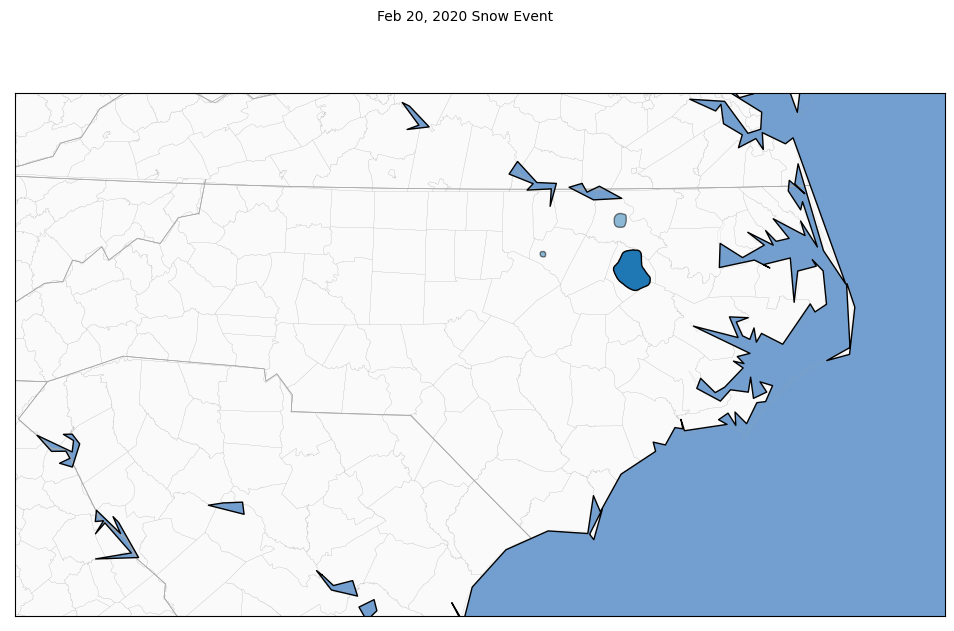

In [7]:
#@title do the thing
clat = 35.28 #NC center
clon = -79.02
wid = 1600000/2
hgt = 900000/2
res = 'l' # [c]rude (faster), [l]ow, [h]ight(slower)
logging.info(f"------------------------")
m = Basemap(width=wid, height=hgt, 
            rsphere=(earth_radius_major, earth_radius_minor),
            resolution=res, area_thresh=50., projection='lcc',
            lat_1=clat, lat_2=clat, lat_0=clat, lon_0=clon)
fig = plt.figure(figsize=(12,8),dpi=100)
ax = fig.add_subplot(111)
draw_map_background(m, ax)
draw_shapes(m, ax)
fig.text(0.5,0.92, 'Feb 20, 2020 Snow Event',horizontalalignment='center')
plt.show()

In [0]:
#@title show logging
!tail -25 mapping.log